# Endometrium analysis - main - clusters visualization

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_primaryall/cluster_markers/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.4 anndata==0.6.22rc1 umap==0.3.10 numpy==1.17.5 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

# Prepare INPUT

## Load andata

In [2]:
adata = sc.read('data/endometrium-N2-clean-manifold.h5ad')
adata.X.shape

(65191, 26245)

### Load cell clusters annotation

In [3]:
meta = pd.read_csv('data/cell_annotations/endometrium_cellannotation_figure1_20200610.csv')
meta = meta.set_index('index')

### Transfer cluster annotation labels

Remove barcodes not in meta

In [4]:
barcodes = meta.index.tolist()
adata = adata[[ i in barcodes for i in adata.obs_names]]

Now transfer labels

Trying to set attribute `.obs` of view, making a copy.
... storing 'clusters' as categorical


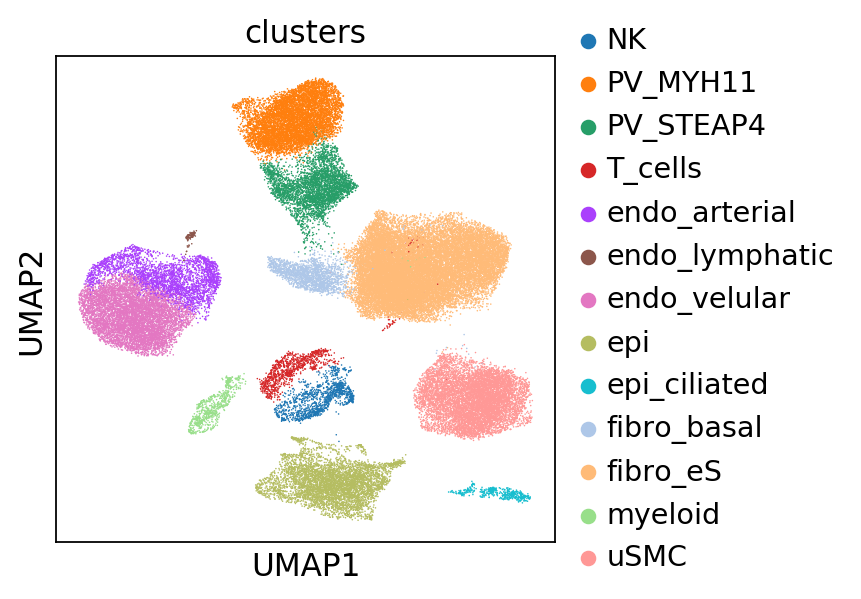

In [5]:
cell_annot = meta['clusters'].to_dict()
adata.obs['clusters'] = [ cell_annot[str(i)] for i in adata.obs_names ]
sc.pl.umap(adata, color=['clusters'])

In [6]:
adata.obs['clusters'].cat.categories

Index(['NK', 'PV_MYH11', 'PV_STEAP4', 'T_cells', 'endo_arterial',
       'endo_lymphatic', 'endo_velular', 'epi', 'epi_ciliated', 'fibro_basal',
       'fibro_eS', 'myeloid', 'uSMC'],
      dtype='object')

# DEGs

Process data to run limma

In [7]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

                counts     freqs
categories                      
NK                1295  0.020890
PV_MYH11          7255  0.117035
PV_STEAP4         3862  0.062300
T_cells           1026  0.016551
endo_arterial     2930  0.047266
endo_lymphatic     101  0.001629
endo_velular      6908  0.111437
epi               5279  0.085159
epi_ciliated       498  0.008034
fibro_basal       1940  0.031295
fibro_eS         22004  0.354960
myeloid            728  0.011744
uSMC              8164  0.131699


(61990, 25132)

Downsample clusters with > n cells - take n cells

In [8]:
import random
from itertools import chain

# Find clusters with > n cells
n = 2000
cluster_counts = adata_count.obs['clusters'].values.describe()
cl2downsample = cluster_counts.index[ cluster_counts['counts'] > n ]

# save all barcode ids from small clusters
holder = []
holder.append( adata_count.obs_names[[ i not in cl2downsample for i in adata_count.obs['clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = adata_count[[ i == cl for i in adata_count.obs['clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
adata_count = adata_count[[ i in samples for i in adata_count.obs_names ]]
adata_count.X.shape

PV_MYH11
PV_STEAP4
endo_arterial
endo_velular
epi
fibro_eS
uSMC


(19588, 25132)

In [9]:
print(adata_count.obs['clusters'].values.describe())

                counts     freqs
categories                      
NK                1295  0.066112
PV_MYH11          2000  0.102103
PV_STEAP4         2000  0.102103
T_cells           1026  0.052379
endo_arterial     2000  0.102103
endo_lymphatic     101  0.005156
endo_velular      2000  0.102103
epi               2000  0.102103
epi_ciliated       498  0.025424
fibro_basal       1940  0.099040
fibro_eS          2000  0.102103
myeloid            728  0.037166
uSMC              2000  0.102103


prepare objects for R

In [10]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [11]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AAACCTGTCAACACTG,endo_velular,A10,CBTM
1,4861STDY7309368_AAAGATGAGTTCGCAT,fibro_basal,A10,CBTM
2,4861STDY7309368_AAAGATGGTCGCTTTC,PV_MYH11,A10,CBTM
3,4861STDY7309368_AAAGCAAGTCTCTTAT,PV_STEAP4,A10,CBTM
4,4861STDY7309368_AAAGTAGAGACTTGAA,PV_MYH11,A10,CBTM


In [12]:
outpath = str(sc.settings.figdir)

In [13]:
%load_ext rpy2.ipython

In [ ]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 2)
    results$AveExpr_rest = round(results$AveExpr_rest, 2)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 2)
    results$percentExpr_rest = round(results$percentExpr_rest, 2)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AAACCTGTCAACACTG" "4861STDY7309368_AAAGATGAGTTCGCAT"
[3] "4861STDY7309368_AAAGATGGTCGCTTTC"
[1] "4861STDY7309368_AAACCTGTCAACACTG" "4861STDY7309368_AAAGATGAGTTCGCAT"
[3] "4861STDY7309368_AAAGATGGTCGCTTTC"


R[write to console]: 19588 shared cells

R[write to console]: uSMC

R[write to console]: Cells in cluster 2000
Cells in rest 17588

